# Week 4: NLP Disaster Tweets Kaggle Mini-Project

This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP).



In [44]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math
from random import sample

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/missmoah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/missmoah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/missmoah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Step 1
**Brief description of the problem and data (5 pts)**

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data

In this project, I will use the the Disaster Tweet dataset from Kaggle. The dataset has binary labels (disaster vs. not disaster). I will build an deep NLP model to classify the tweets to either "disaster" or "not disaster"

The tweets have 3 meaningful features: the full text, the location, and keyword. 

In [12]:
# Some info about the dataset
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [13]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [14]:
print(train_df.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [15]:
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## Step 2
**Exploratory data analysis (EDA) -- Inspect, Visualize and Clean the data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis.

There are 7613 data points in training set. I will create some histograms to have better understanding of the dataset. 

Then, I will transform the data using TFIDF after removing the stopwords.

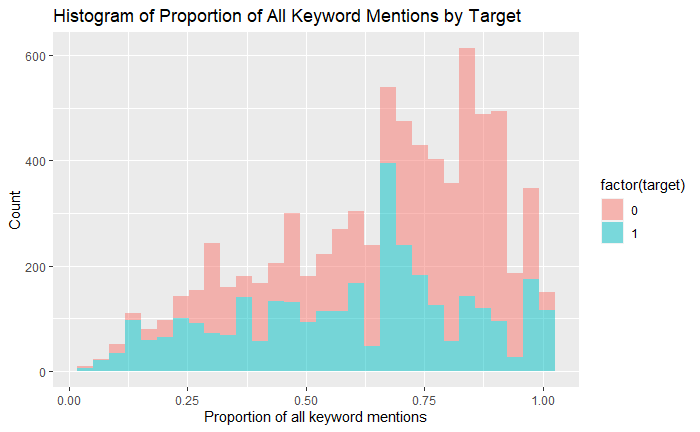

In [16]:
# Remove keyword and location features from datasets
train_df = train_df[["id", "text", "target"]].sort_values(by="id")
test_df = test_df[["id", "text"]].sort_values(by="id")

train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
# Preprocess the text field
def text_preprocessing(text:pd.Series) -> pd.Series:
    for word in range(len(text)):
        words_l = re.sub('[^a-zA-Z]', ' ', text[word])
        # Make all words to lowercase and tokenize the text
        words_l = (words_l.lower()).split()
        
        #Remove stopwords
        words_l = [w for w in words_l if not w in set(stopwords.words('english'))]
        
        # Lemmatize the text
        lem = WordNetLemmatizer()
        words_l = [lem.lemmatize(w) for w in words_l if len(w) > 1]
        
        words_l = ' '.join(words_l)
        text[word] = words_l
        
    return text

train_df["text"] = text_preprocessing(train_df["text"])
test_df["text"] = text_preprocessing(test_df["text"])

In [18]:
train_df.head()

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la ronge sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1


## Step 3
**Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge. you can use any resources needed, but make sure you "demosntrate" you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (you may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.)?

I'll process the text using TF-IDF.

In [19]:
# Feature extraction with TF-IDF
train_text_l = train_df["text"].tolist()
tfidf = TfidfVectorizer(max_features=1000)
text_tfidf = tfidf.fit(train_text_l)

train_text_transformed = text_tfidf.transform(train_df["text"]).todense()

X_train, X_val, y_train, y_val = train_test_split(train_text_transformed, train_df["target"], test_size=0.2, random_state=42)

X_test = text_tfidf.transform(test_df["text"]).todense()


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(6090, 1000) (6090,)
(1523, 1000) (1523,)
(3263, 1000)


I'll build a RNN model using tensorflow. 

In [26]:
def ann_model(eta):
    n = (1000, )
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta,
                                                                 decay_steps=1000,
                                                                 decay_rate=0.9)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=n))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return(model)

In [27]:
# Print out the model info
model = ann_model(0.0001)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 144,769
Trainable params: 144,769
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Hyperparater tuning with grid search
def grid_search(eta_l, X_train, y_train, X_val, y_val):
    callbacks_l = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")]
    
    cur_best = (0, None, None)
    
    for eta in eta_l:
        print("Learning rate: ", eta)
        cur_model = ann_model(eta)
        cur_his = cur_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=50, callbacks=callbacks_l, verbose=0)
        
        print("Current training accuracy: ", cur_his.history["accuracy"][-1])
        print("Current validation accuracy: ", cur_his.history["val_accuracy"][-1])
        if cur_his.history["val_accuracy"][-1] > cur_best[0]:
            cur_best = (cur_his.history["val_accuracy"][-1], cur_his, eta)
        print()
        
    return(cur_best[1:])

In [33]:
eta_l = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
(best_his, best_eta) = grid_search(eta_l, X_train, y_train, X_val, y_val)

Learning rate:  1e-05
Current training accuracy:  0.6625615954399109
Current validation accuracy:  0.6513460278511047

Learning rate:  5e-05
Current training accuracy:  0.8472906351089478
Current validation accuracy:  0.7898883819580078

Learning rate:  0.0001
Current training accuracy:  0.8600985407829285
Current validation accuracy:  0.7879185676574707

Learning rate:  0.0005
Current training accuracy:  0.9021346569061279
Current validation accuracy:  0.7780696153640747

Learning rate:  0.001
Current training accuracy:  0.9407225251197815
Current validation accuracy:  0.780039370059967

Learning rate:  0.005
Current training accuracy:  0.9349753856658936
Current validation accuracy:  0.7793828248977661

Learning rate:  0.01
Current training accuracy:  0.9293924570083618
Current validation accuracy:  0.7721602320671082



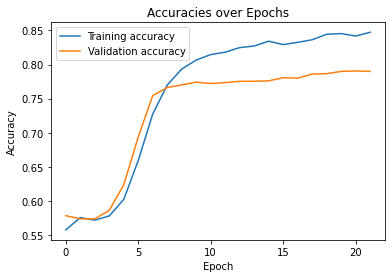

In [40]:
# Accuracy figure
epochs_l = [i for i in range(len(best_his.history["accuracy"]))]

line_1, = plt.plot(epochs_l, best_his.history["accuracy"], zorder=0, label = "Training accuracy")
line_2, = plt.plot(epochs_l, best_his.history["val_accuracy"], zorder=1, label="Validation accuracy")

plt.legend(handles=[line_1, line_2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracies over Epochs")
plt.show()

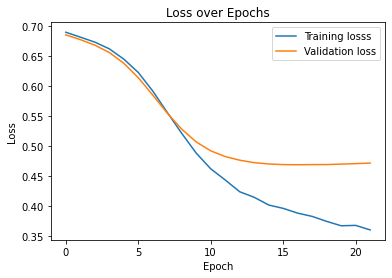

In [41]:
# Loss figure
epochs_l = [i for i in range(len(best_his.history["loss"]))]

line_1, = plt.plot(epochs_l, best_his.history["loss"], zorder=0, label = "Training losss")
line_2, = plt.plot(epochs_l, best_his.history["val_loss"], zorder=1, label="Validation loss")

plt.legend(handles=[line_1, line_2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()

In [43]:
# Test set
y_hat = best_his.model.predict(X_test)
y_hat = y_hat.reshape(y_hat.shape[0])
y_hat = list(y_hat)
predictions_l = [round(y_hat[i]) for i in range(len(y_hat))]

test_df["target"] = predictions_l
test_df.to_csv("./test_set_with_predictions_ann.csv")

102/102 [==============================] - 0s 679us/step


## Step 4
**Results and Anlaysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [63]:
# Build RNN model for comparison, Hyperparameter optimization with RNN
val_size = 0.08
num_train = math.floor((1 - val_size) * train_df.shape[0])
train_index = sample([i for i in range(train_df.shape[0])], num_train)
val_index = [i for i in range(train_df.shape[0]) if not i in train_index]

training_df = train_df.iloc[train_index]
val_df = train_df.iloc[val_index]

train_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(training_df["text"].values, tf.string),
                                                   tf.cast(training_df["target"].values, tf.int32))))

val_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(val_df["text"].values, tf.string),
                                                   tf.cast(val_df["target"].values, tf.int32))))

test_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(test_df["text"].values, tf.string))))

BUFFER_SIZE = 10000
BATCH_SIZE = 10

# Shuffle the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(train_dataset.map(lambda text, label: text))

def rnn_model(eta):
    model = tf.keras.Sequential([encoder, 
                                 tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                                           output_dim=128, mask_zero=True),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(1, activation="sigmoid")])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta,
                                                                 decay_steps=1000, decay_rate=0.9)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="binary_crossentropy", metrics=["accuracy"])
    
    return(model)

def grid_search_rnn(eta_l, train_dataset):
    callbacks_l = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")]
    
    cur_best= (0, None, None)
    for eta in eta_l:
        print("Learning rate: ", eta)
        cur_model = rnn_model(eta)
        cur_his = cur_model.fit(train_dataset, validation_data=val_dataset, epochs=50, 
                                callbacks=callbacks_l, verbose=0)
        
        print("Training accuracy: ", cur_his.history["accuracy"][-1])
        print("Validation accuracy: ", cur_his.history["val_accuracy"][-1])
        print()
        
        if cur_his.history["val_accuracy"][-1] > cur_best[0]:
            cur_best = (cur_his.history["val_accuracy"][-1], cur_his, eta)
        
    return(cur_best[1:])

2023-06-06 13:14:44.150642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [7003]
	 [[{{node Placeholder/_1}}]]
2023-06-06 13:14:44.150806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [7003]
	 [[{{node Placeholder/_1}}]]


In [64]:
eta_l = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
(best_his, best_eta) = grid_search_rnn(eta_l, train_dataset)

Learning rate:  1e-05


2023-06-06 13:14:46.995801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [7003]
	 [[{{node Placeholder/_1}}]]
2023-06-06 13:14:46.996028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [7003]
	 [[{{node Placeholder/_1}}]]
2023-06-06 13:14:48.333827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' 

Training accuracy:  0.7983721494674683
Validation accuracy:  0.7639344334602356

Learning rate:  5e-05


2023-06-06 13:20:05.937530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-06 13:20:07.506998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


Training accuracy:  0.8524917960166931
Validation accuracy:  0.7918033003807068

Learning rate:  0.0001


2023-06-06 13:21:14.700266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-06 13:21:16.250876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


Training accuracy:  0.8694844841957092
Validation accuracy:  0.7754098176956177

Learning rate:  0.0005


2023-06-06 13:22:23.634122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-06 13:22:25.528817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


Training accuracy:  0.8920462727546692
Validation accuracy:  0.7672131061553955

Learning rate:  0.001


2023-06-06 13:23:07.895104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-06 13:23:09.518456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


Training accuracy:  0.9218906164169312
Validation accuracy:  0.7672131061553955



In [65]:
best_his.model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_69 (Dense)            (None, 64)                16448     
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_70 (Dense)            (None, 16)              

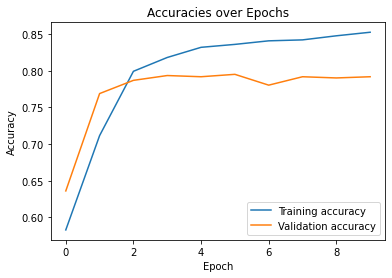

In [66]:
# Accuracy figure
epochs_l = [i for i in range(len(best_his.history["accuracy"]))]

line_1, = plt.plot(epochs_l, best_his.history["accuracy"], zorder=0, label = "Training accuracy")
line_2, = plt.plot(epochs_l, best_his.history["val_accuracy"], zorder=1, label="Validation accuracy")

plt.legend(handles=[line_1, line_2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracies over Epochs")
plt.show()

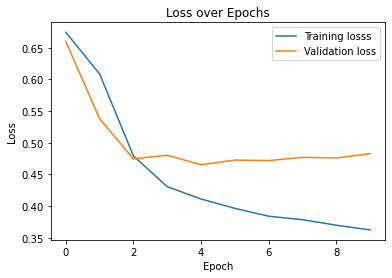

In [67]:
# Loss figure
epochs_l = [i for i in range(len(best_his.history["loss"]))]

line_1, = plt.plot(epochs_l, best_his.history["loss"], zorder=0, label = "Training losss")
line_2, = plt.plot(epochs_l, best_his.history["val_loss"], zorder=1, label="Validation loss")

plt.legend(handles=[line_1, line_2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()

In [68]:
print(best_eta)

5e-05


In [69]:
# Test set
y_hat = best_his.model.predict(test_dataset)
y_hat = y_hat.reshape(y_hat.shape[0])
y_hat = list(y_hat)
predictions_l = [round(y_hat[i]) for i in range(len(y_hat))]

test_df["target"] = predictions_l
test_df.to_csv("./test_set_with_predictions_rnn.csv")

2023-06-06 13:28:04.525074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3263]
	 [[{{node Placeholder/_0}}]]


327/327 [==============================] - 2s 3ms/step


## Step 5
**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

I compared two different model architectures: ANN and RMM. RNN performs slightly better than ANN. 


**References**:
1. https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168

2. https://www.tensorflow.org/text/tutorials/text_classification_rnn